In [1]:
import pandas as pd
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from matplotlib.lines import Line2D
from collections import Counter
from nameparser import HumanName
import gender_guesser.detector as gender
from scipy.stats import chi2_contingency
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import remove_non_sample as rns
import numpy as np


In [2]:
# File Paths
absolute_path = "C:\\Users\\tykun\\\OneDrive\\Documents\\SchoolDocs\VSCodeProjects\\connectedData\\board_analysis\\"
altered_dataframes = "altered_dataframes\\"
gpt_dataframes = "gpt_dataframes\\"
graphs = "graphs\\"
scripts =  "scripts\\"
board_dataframes = "board_dataframes\\"

altered_dataframe_path = f"{absolute_path}{altered_dataframes}"
gpt_dataframe_path = f"{absolute_path}{gpt_dataframes}" 
graph_path = f"{absolute_path}{graphs}"
script_path = f"{absolute_path}{scripts}"
boards_path = f"{absolute_path}{board_dataframes}"


# Valid Years
years = ["1999", "2000", "2005", "2007", "2008", "2009", "2011", "2013", "2018"]

In [3]:
def clean_diversity_data(file_path):
    """
    Loads and cleans the diversity statistics data, normalizing columns and handling missing values.

    Args:
        file_path (str): The path to the CSV file containing diversity statistics.

    Returns:
        pd.DataFrame: The cleaned diversity DataFrame.
    """
    diversity_df = pd.read_csv(file_path)
    
    # Normalize the 'female_president' column and map to boolean
    diversity_df['female_president'] = diversity_df['female_president'].astype(str).str.upper().str.strip()
    diversity_df['female_president'] = diversity_df['female_president'].map({'TRUE': True, 'FALSE': False})
    diversity_df['female_president'] = diversity_df['female_president'].fillna(False)  # Fill any remaining NaNs with False

    # Convert 'Year' to numeric and drop rows with invalid 'Year' entries
    diversity_df['Year'] = pd.to_numeric(diversity_df['Year'], errors='coerce').astype('Int64')
    diversity_df.dropna(subset=['Year'], inplace=True)

    # Convert gender-related columns to numeric, filling NaN with 0
    for col in ['female', 'male', 'unknown']:
        diversity_df[col] = pd.to_numeric(diversity_df[col], errors='coerce').fillna(0)

    # Displaying info for verification purposes (can be removed in production)
    print("\nUnique values in 'female_president' after mapping:")
    print(diversity_df['female_president'].unique())
    print("\nData types after conversion:")
    print(diversity_df.dtypes)
    print("\nMissing values per column:")
    print(diversity_df.isna().sum())

    return diversity_df

def plot_cumulative_cpf_for_year(df, year):
    """
    Plots the cumulative frequency distribution (CPF) of female board members for a specified year with an adjusted scale.

    Args:
        df (pd.DataFrame): The DataFrame containing cleaned diversity data.
        year (int): The year for which to generate the CPF plot.

    Returns:
        None
    """
    # Filter data for the specified year
    year_df = df[df['Year'] == year].copy()
    
    # Calculate total board members and female proportion
    year_df['TotalBoardMembers'] = year_df[['female', 'male', 'unknown']].sum(axis=1)
    year_df = year_df[year_df['TotalBoardMembers'] > 0]  # Avoid division by zero
    year_df['FemaleProportion'] = year_df['female'] / year_df['TotalBoardMembers']
    
    # Sort data by FemaleProportion in ascending order
    year_df = year_df.sort_values(by='FemaleProportion').reset_index(drop=True)
    
    # Group by FemaleProportion for unique X values and compute cumulative sums
    grouped_df = year_df.groupby('FemaleProportion').agg({
        'female_president': 'sum',  # Sum the female presidents at each X
        'TotalBoardMembers': 'count'  # Count institutions at each X
    }).reset_index()

    # Cumulative sums for institutions and female presidents
    grouped_df['CumulativeInstitutions'] = grouped_df['TotalBoardMembers'].cumsum()
    grouped_df['CumulativeFemalePresidents'] = grouped_df['female_president'].cumsum()

    # Cumulative proportion of institutions with female presidents
    grouped_df['CumulativeFemalePresidentProportion'] = grouped_df['CumulativeFemalePresidents'] / grouped_df['CumulativeInstitutions']
    print(year, len(grouped_df))

    # Plot the CPF
    plt.figure(figsize=(10, 6))
    plt.plot(grouped_df['FemaleProportion'], grouped_df['CumulativeFemalePresidentProportion'], marker='o', linestyle='-', color="red")
    plt.xlabel('Proportion of Females on Boards (X or fewer)')
    plt.ylabel('Cumulative Proportion of Schools with Female Presidents')
    plt.title(f'CPF Plot for Year {year}')
    plt.xlim(0, 1)  # Set the x-axis to go from 0 to 1
    plt.ylim(0, .3)  # Set the y-axis to go slightly above 1 for better visual range
    plt.grid(True)
    plt.show()



1999 100


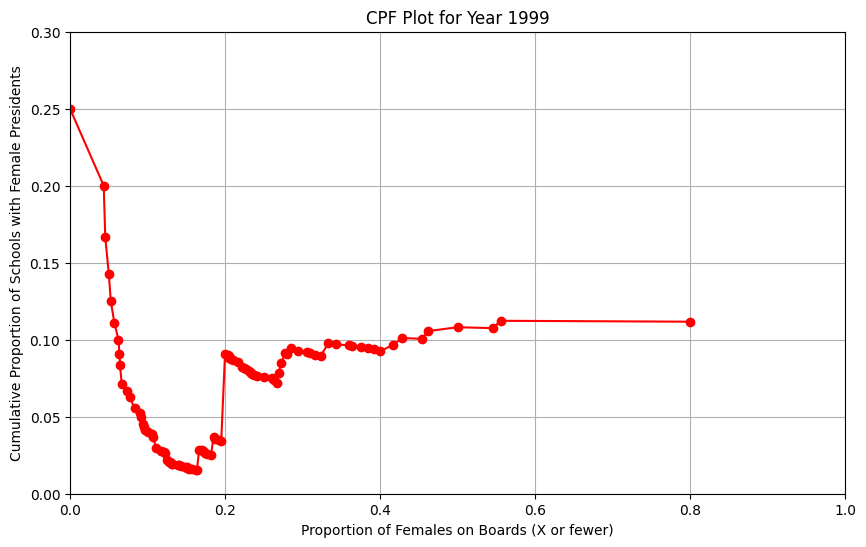

2000 100


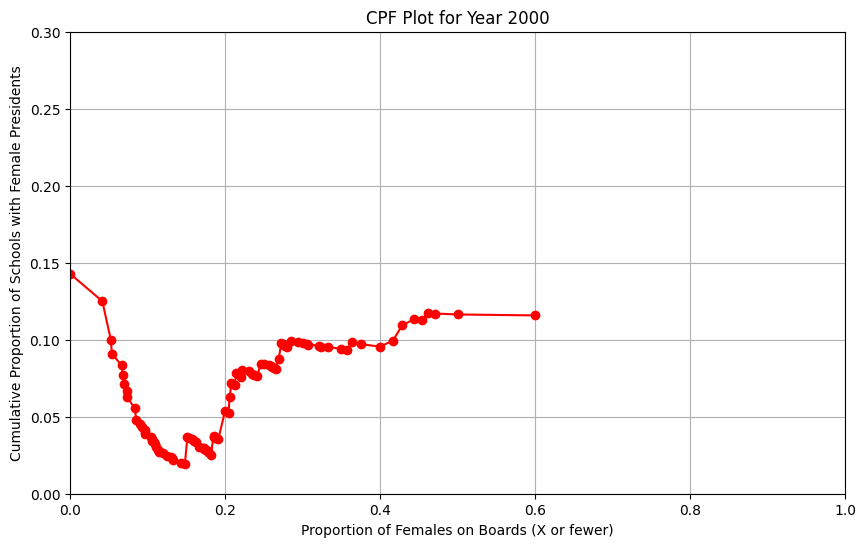

2005 104


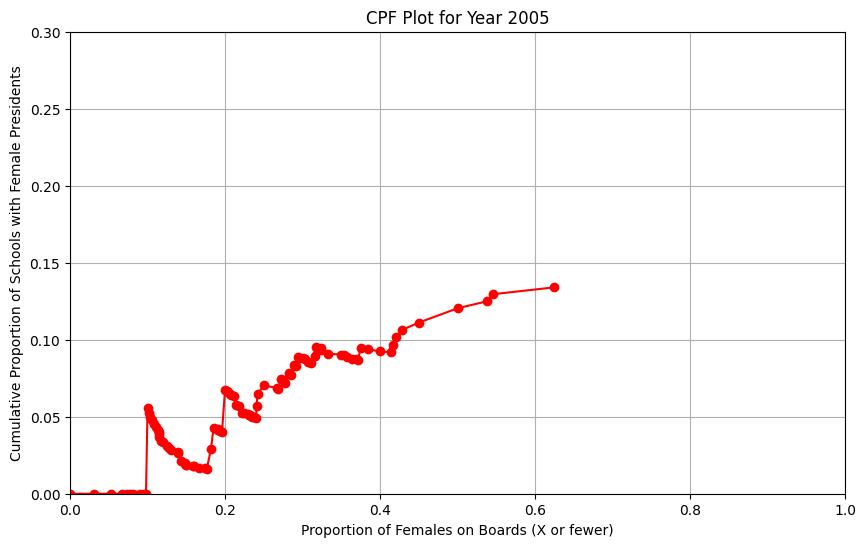

2007 99


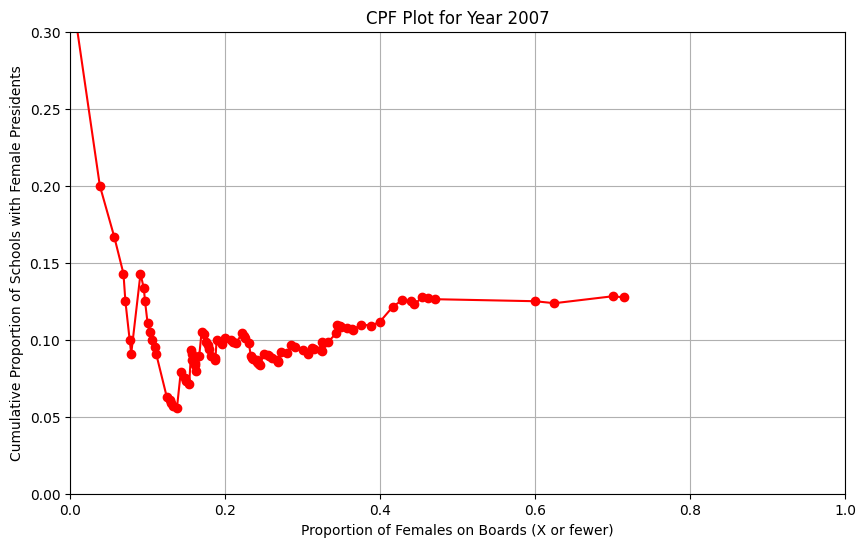

2008 98


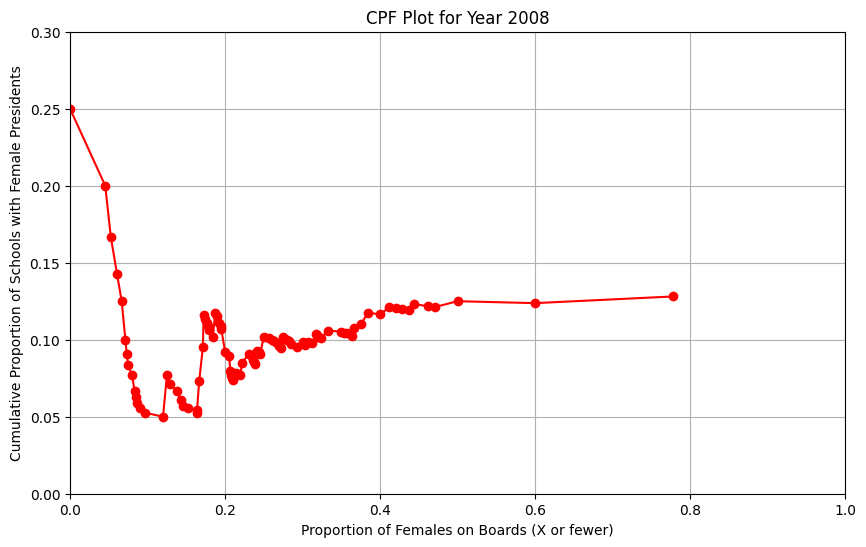

2009 106


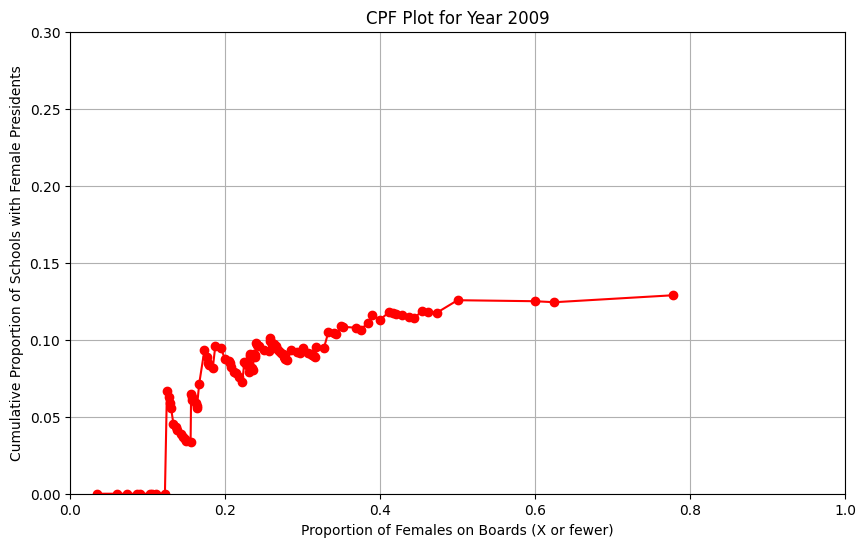

2011 92


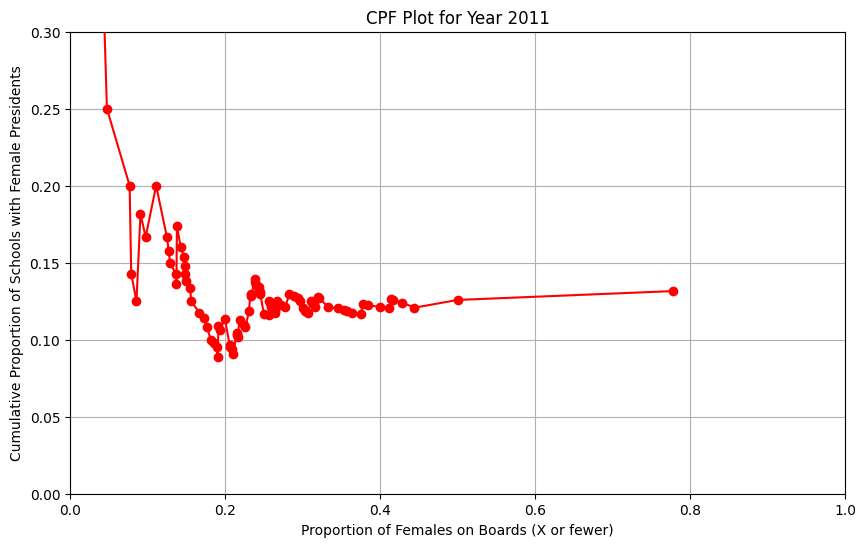

2013 91


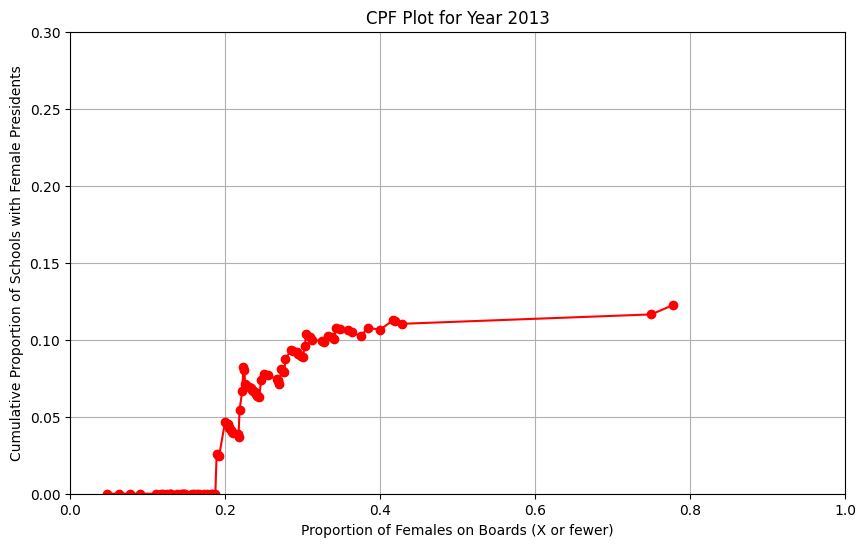

2018 91


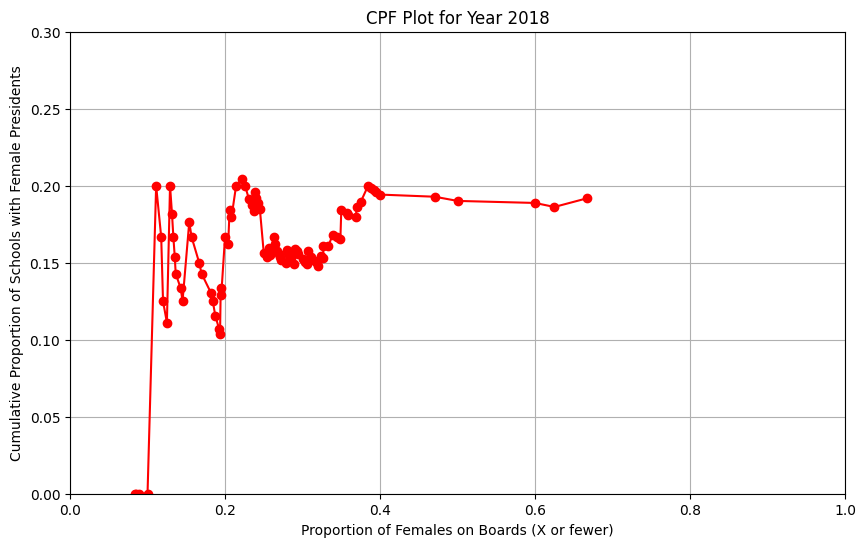

In [4]:
#Created Files
diversity_statistics_path = f"{altered_dataframe_path}sample_board_statistics.csv"
diversity_statistics_df = pd.read_csv(diversity_statistics_path)
diversity_statistics_df = rns.remove_non_samples(diversity_statistics_df)
for year in years:
    plot_cumulative_cpf_for_year(diversity_statistics_df, int(year))

In [5]:
def plot_cumulative_cpf_for_two_years(df, year1, year2):
    """
    Plots the cumulative frequency distribution (CPF) of female board members for two specified years
    on the same graph for comparison.

    Args:
        df (pd.DataFrame): The DataFrame containing cleaned diversity data.
        year1 (int): The first year for which to generate the CPF plot.
        year2 (int): The second year for which to generate the CPF plot.

    Returns:
        None
    """
    def calculate_grouped_cpf(df, year):
        # Filter data for the specified year
        year_df = df[df['Year'] == year].copy()
        
        # Calculate total board members and female proportion
        year_df['TotalBoardMembers'] = year_df[['female', 'male', 'unknown']].sum(axis=1)
        year_df = year_df[year_df['TotalBoardMembers'] > 0]  # Avoid division by zero
        year_df['FemaleProportion'] = year_df['female'] / year_df['TotalBoardMembers']
        
        # Sort data by FemaleProportion in ascending order
        year_df = year_df.sort_values(by='FemaleProportion').reset_index(drop=True)
        
        # Group by FemaleProportion for unique X values and compute cumulative sums
        grouped_df = year_df.groupby('FemaleProportion').agg({
            'female_president': 'sum',  # Sum the female presidents at each X
            'TotalBoardMembers': 'count'  # Count institutions at each X
        }).reset_index()

        # Cumulative sums for institutions and female presidents
        grouped_df['CumulativeInstitutions'] = grouped_df['TotalBoardMembers'].cumsum()
        grouped_df['CumulativeFemalePresidents'] = grouped_df['female_president'].cumsum()

        # Cumulative proportion of institutions with female presidents
        grouped_df['CumulativeFemalePresidentProportion'] = (
            grouped_df['CumulativeFemalePresidents'] / grouped_df['CumulativeInstitutions']
        )
        
        return grouped_df
    
    # Get grouped data for each year
    grouped_df1 = calculate_grouped_cpf(df, year1)
    grouped_df2 = calculate_grouped_cpf(df, year2)

    # Plot the CPF for both years
    plt.figure(figsize=(12, 8))
    plt.plot(grouped_df1['FemaleProportion'], grouped_df1['CumulativeFemalePresidentProportion'],
             marker='o', linestyle='-', color='blue', label=f'Year {year1}')
    plt.plot(grouped_df2['FemaleProportion'], grouped_df2['CumulativeFemalePresidentProportion'],
             marker='s', linestyle='--', color='red', label=f'Year {year2}')
    
    # Label the plot
    plt.xlabel('Proportion of Females on Boards (X or fewer)')
    plt.ylabel('Cumulative Proportion of Schools with Female Presidents')
    plt.title(f'CPF for {year1} and {year2}')
    plt.xlim(0, 1)  # Set the x-axis to go from 0 to 1
    plt.ylim(0, 0.3)  # Set the y-axis to match expected range
    plt.grid(True)
    plt.legend()
    plt.show()


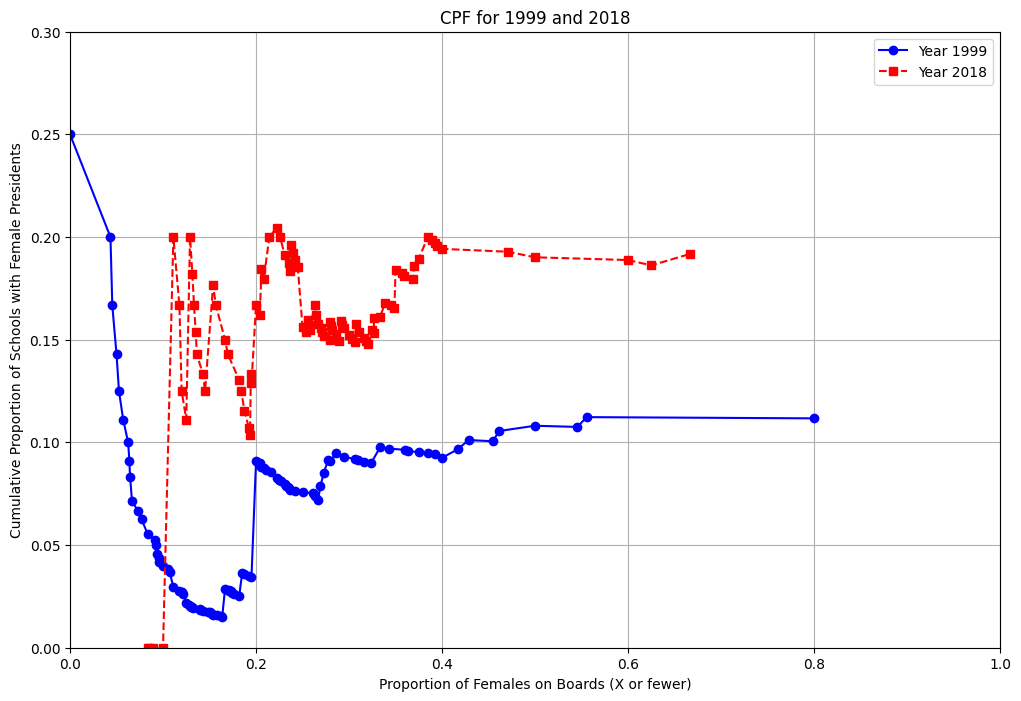

In [6]:
plot_cumulative_cpf_for_two_years(diversity_statistics_df, 1999, 2018)